In [33]:
NAME = "Poojitha Pasala"
EMAIL = "poojithapasala@arizona.edu"
Topic = "LING 582 Class Competition 2024"

## Import Required libraries

In [34]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import nltk

## Pre-processing Text

In [35]:
# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

def custom_preprocessor(text):
    """
    Custom text preprocessing function that retains stylistic markers
    important for authorship profiling.
    """
    url_exp = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))'
    quote_exp = r'["“”]'

    #  Convert the text to lowercase and remove unneeded punctuation, while keeping important style elements
    text = text.lower()
    text = re.sub(url_exp, '<URL>', text)
    text = re.sub(quote_exp, '', text)  # Remove quotes

    # Retaining common punctuation, removing stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Load the train and test data with UTF-8 encoding
train_df = pd.read_csv("train.csv", encoding='utf-8')
test_df = pd.read_csv("test.csv", encoding='utf-8')

# Handling missing values in the 'TEXT' column
train_df['TEXT'] = train_df['TEXT'].fillna('')
test_df['TEXT'] = test_df['TEXT'].fillna('')

# Applying custom pre-processing to the text data
train_df['TEXT'] = train_df['TEXT'].apply(custom_preprocessor)
test_df['TEXT'] = test_df['TEXT'].apply(custom_preprocessor)

## Data Visualization for EDA

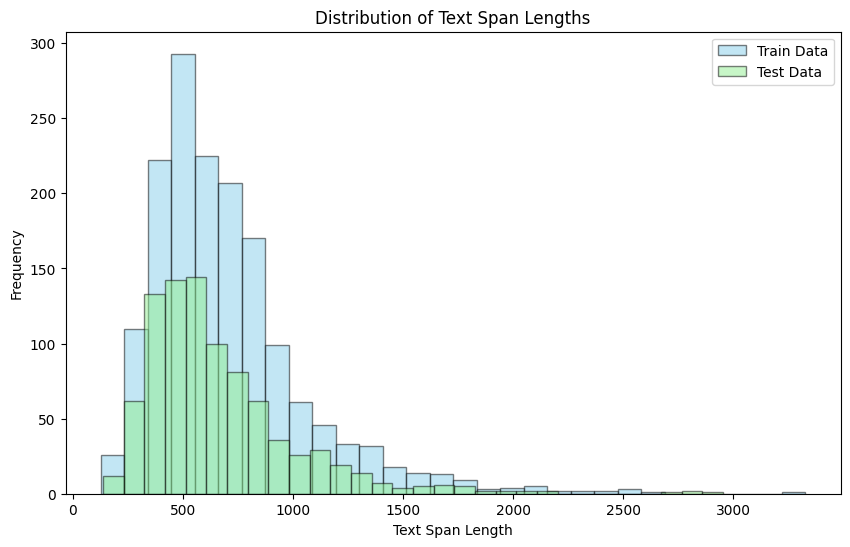

Train Label Distribution:
 LABEL
0    1245
1     356
Name: count, dtype: int64


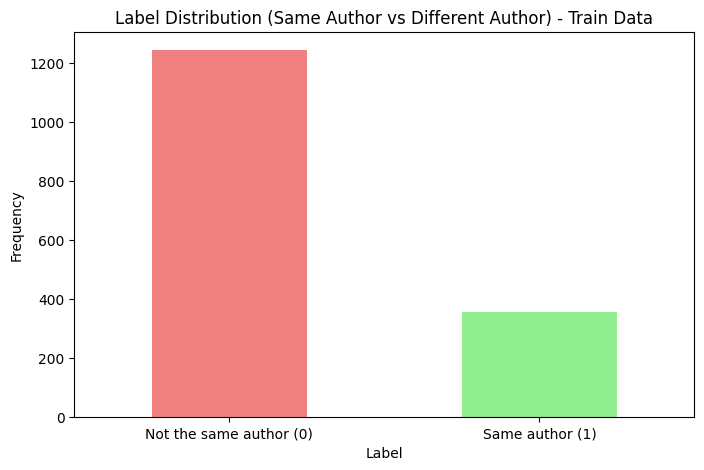

Missing values in train TEXT column: 0
Missing values in test TEXT column: 0


In [37]:

# 1. Analyzing Text Span Lengths for Both Train and Test Data
train_df['TEXT_LENGTH'] = train_df['TEXT'].apply(len)
test_df['TEXT_LENGTH'] = test_df['TEXT'].apply(len)

# Plotting the distribution of text span lengths for both training and test data
plt.figure(figsize=(10, 6))
plt.hist(train_df['TEXT_LENGTH'], bins=30, alpha=0.5, label='Train Data', color='skyblue', edgecolor='black')
plt.hist(test_df['TEXT_LENGTH'], bins=30, alpha=0.5, label='Test Data', color='lightgreen', edgecolor='black')
plt.title('Distribution of Text Span Lengths')
plt.xlabel('Text Span Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. Analyzing Label Distribution (Class Imbalance) for Train Data
label_counts_train = train_df['LABEL'].value_counts()
print("Train Label Distribution:\n", label_counts_train)

# Plotting the class distribution for training data
plt.figure(figsize=(8, 5))
label_counts_train.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Label Distribution (Same Author vs Different Author) - Train Data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Not the same author (0)', 'Same author (1)'], rotation=0)
plt.show()

# Checking for missing values in the 'TEXT' column of both train and test datasets
train_missing = train_df['TEXT'].isnull().sum()
test_missing = test_df['TEXT'].isnull().sum()

# Printing the count of missing values
print(f"Missing values in train TEXT column: {train_missing}")
print(f"Missing values in test TEXT column: {test_missing}")

## Word and Character Diversity

In [38]:
# Count unique words per text
train_df['unique_words'] = train_df['TEXT'].apply(lambda x: len(set(x.split())))
class_unique_words = train_df.groupby('LABEL')['unique_words'].mean()
print("Average Unique Words per Class:\n", class_unique_words)

# Count unique characters per text
train_df['unique_chars'] = train_df['TEXT'].apply(lambda x: len(set(x)))
class_unique_chars = train_df.groupby('LABEL')['unique_chars'].mean()
print("Average Unique Characters per Class:\n", class_unique_chars)


Average Unique Words per Class:
 LABEL
0    91.355823
1    89.856742
Name: unique_words, dtype: float64
Average Unique Characters per Class:
 LABEL
0    33.206426
1    32.867978
Name: unique_chars, dtype: float64


##Vocabulary Diversity

In [39]:
def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0

train_df['TTR'] = train_df['TEXT'].apply(calculate_ttr)
class_ttr = train_df.groupby('LABEL')['TTR'].mean()
print("Average Type-Token Ratio per Class:\n", class_ttr)


Average Type-Token Ratio per Class:
 LABEL
0    0.940136
1    0.930261
Name: TTR, dtype: float64


## Diversity in stylometric features

In [40]:
# Average word length per text
train_df['avg_word_length'] = train_df['TEXT'].apply(lambda x: np.mean([len(word) for word in x.split()]))
class_avg_word_length = train_df.groupby('LABEL')['avg_word_length'].mean()
print("Average Word Length per Class:\n", class_avg_word_length)

Average Word Length per Class:
 LABEL
0    6.156452
1    6.131367
Name: avg_word_length, dtype: float64


## Feature Engineering with TF-IDF Vectorization

In [41]:
# Initializing a TF-IDF vectorizer to extract features using character-level n-grams
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=30000)
X_train = vectorizer.fit_transform(train_df['TEXT'])
X_test = vectorizer.transform(test_df['TEXT'])
y_train = train_df['LABEL']

## Class Imbalance Handling and Hyperparameter Tuning for Logistic Regression

In [42]:
# Calculating class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight('balanced', classes=pd.unique(y_train), y=y_train)

# Configuring a grid search to tune the hyperparameters of the Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, class_weight=dict(zip(pd.unique(y_train), class_weights)))
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extracting the best model
best_model = grid_search.best_estimator_

# Printing the best parameters
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

Best Parameters from GridSearchCV: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


## Model Evaluation, Training, and Prediction

In [43]:
# Cross-validating the best model to get an F1 score estimate
cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_weighted')
print("Cross-Validation F1-score:", cv_f1.mean())

# Training the optimal model using the complete training dataset and generate predictions for the test data
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Saving predictions to a CSV file
test_df['LABEL'] = y_test_pred
test_df[['ID', 'LABEL']].to_csv("submission.csv", index=False, encoding='utf-8')
print('Test set predictions saved to submission.csv')

Cross-Validation F1-score: 0.695750998104397
Test set predictions saved to submission.csv
